In [1]:
%matplotlib widget
from typing import Tuple, Dict
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm

import seaborn as sns

from opinion_model import (
    average_k,
    generate_opinions, describe_graph,
    Opinion, balance_opinions,
    SUGGESTABILITY_KEY, OPINION_KEY
)

from opinion_model.utils import read_graph


from opinion_model.comminity_model import CommunityOpinionModel

# Другие данные (не нужно)

In [2]:
def load_data(path: str, processed: bool = True):
    file = 'processed.csv' if processed else 'raw.csv'
    index_col = 0 if processed else None
    return pd.read_csv(os.path.join(path, file), index_col=index_col)

In [14]:
k4compact = load_data('data/community-effect/compact_erd_ren_k4_n2000/', processed=False)
k8compact = load_data('data/community-effect/compact_erd_ren_k8_n2000/')
k4noncompact = load_data('data/community-effect/noncompact_erd_ren_k4_n2000/')
k8noncompact = load_data('data/community-effect/noncompact_erd_ren_k8_n2000/')

In [15]:
k4compact

,Unnamed: 0,nodes,n_components,n_minus_components,avg_k,fraction,s1,s2,op_clust_sizes,s1_persistence,s2_persistence,s1_change_op,s2_change_op,f,real_f,sug,community_coef,stable,steps
0,0,971,1,40,3.975283,0.047374,0.003090,0.002060,"[3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.000000,1.0,0.000000,0.0,0.000000,0.047374,0,1,True,1
1,1,971,1,2,3.975283,0.025747,0.023687,0.002060,"[23, 2]",0.869565,1.0,0.130435,0.0,0.111111,0.025747,0,1,True,7
2,2,971,1,8,3.975283,0.093718,0.081359,0.004119,"[79, 4, 2, 2, 1, 1, 1, 1]",0.797468,1.0,0.151899,0.0,0.222222,0.093718,0,1,True,13
3,3,971,1,2,3.975283,0.250257,0.249228,0.001030,"[242, 1]",0.826446,1.0,0.128099,0.0,0.333333,0.250257,0,1,True,9
4,4,971,1,6,3.975283,0.450051,0.444902,0.001030,"[432, 1, 1, 1, 1, 1]",0.824074,1.0,0.129630,0.0,0.444444,0.450051,0,1,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120055,120055,981,1,3,3.912334,0.659531,0.657492,0.001019,"[645, 1, 1]",0.762791,1.0,0.193798,0.0,0.555556,0.659531,0,30,True,10
120056,120056,981,1,1,3.912334,0.864424,0.864424,0.000000,[848],0.751179,NaN,0.219340,NaN,0.666667,0.864424,0,30,True,7
120057,120057,981,1,1,3.912334,0.942915,0.942915,0.000000,[925],0.784865,NaN,0.202162,NaN,0.777778,0.942915,0,30,True,7
120058,120058,981,1,1,3.912334,0.967380,0.967380,0.000000,[949],0.864067,NaN,0.124341,NaN,0.888889,0.967380,0,30,True,5


In [4]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    # print(miny+dy, maxy+dy)
    ax2.set_ylim(miny+dy, maxy+dy)


def create_joined_plot(
        fig: plt.Figure,
        main_ax: plt.Axes,
        data: pd.DataFrame,
        plot_s2_err: bool = True,
        show_xlabel: bool = True,
        show_ylabel=True,
        show_2ylabel: bool = True,
        v1=0, v2=0,
        show_legend: bool = False,
        fontsize: int = 18
        ):
    color = 'tab:red'

    if show_xlabel:
        main_ax.set_xlabel('f', fontsize=fontsize)
    if show_ylabel:
        main_ax.set_ylabel('fraction, $s_1$', color=color, fontsize=fontsize)
    main_ax.grid(True)

    # main_ax.set_ylim(bottom=0, top=1)
    main_ax.plot(data.f, data.fraction_mean, '--r', alpha=0.3)
    main_ax.fill_between(data.f, data.fraction_mean - data.fraction_std, data.fraction_mean + data.fraction_std,
                     color='gray', alpha=0.2)

    lns2 = main_ax.plot(data.f, data.s1_mean, '.g', label='s1')
    main_ax.plot(data.f, data.s1_mean, '--g', alpha=0.3)

    lns1 = main_ax.plot(data.f, data.fraction_mean, '.r', label='fraction')

    secondary_ax = main_ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    if show_2ylabel:
        secondary_ax.set_ylabel('$s_2$', color=color, fontsize=fontsize)  # we already handled the x-label with ax1
    lns3 = secondary_ax.plot(data.f, data.s2_mean, '.b', label='s2')
    secondary_ax.plot(data.f, data.s2_mean, '--', alpha=0.3)
    if plot_s2_err:
        secondary_ax.fill_between(data.f, data.s2_mean - data.s2_std, data.s2_mean + data.s2_std,
                         color='gray', alpha=0.1)
    # ax2.errorbar(result.index, result.s2_mean, fmt='.', color=color, yerr=result.s2_std, label='s2')
    secondary_ax.tick_params(axis='y', labelcolor=color)
    secondary_ax.set_ybound(upper=data.s2_mean.max() + 0.001)

    if show_legend:
        lns = lns1+lns2+lns3
        labs = [l.get_label() for l in lns]
        main_ax.legend(lns, labs)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if data.s1_mean.min() != 0 and v2 == 0:
        v1 = data.s1_mean.min()
        v2 = data.s2_mean.min()
    align_yaxis(main_ax, v1, secondary_ax, v2)

In [5]:
k4compact.index.unique()

Index([1, 2, 5, 10, 20, 30], dtype='int64', name='community_coef')

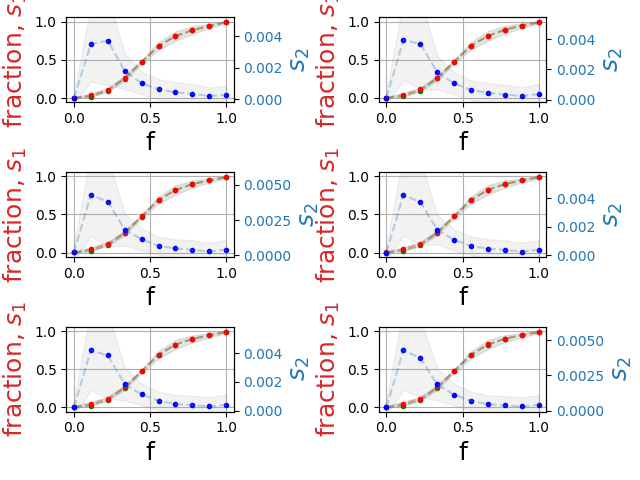

In [6]:
fig, axs = plt.subplots(3, 2)

data = k4compact

for ax, co in zip(axs.flatten(), data.index.unique()):
    create_joined_plot(fig, ax, data.loc[co])

In [16]:
network = read_graph('networks/erdos-renyi/k=4/network_1050.graphml')

In [25]:
model = CommunityOpinionModel()

In [26]:
model.set_graph(network)

In [27]:
model.community_coefficient = 1
opinions = generate_opinions(network, 0.2, compact=False, seed=42)
nodes = network.nodes()
opinions_array = np.fromiter(
    (opinions[node] for node in nodes),
    dtype=int
)
model.opinions = opinions_array

In [28]:
model.balance_opinions()

7

In [30]:
model.opinions.sum()

974

In [31]:
len(nodes)

974

In [118]:
from scripts.eval_comm_opinions import load_networks
from opinion_model.comminity_model import CommunityOpinionModel

In [119]:
from pathlib import Path

In [27]:
rng = np.random.default_rng(42)

fsss = []
for graph in load_networks(Path('networks/erdos-renyi/k=4/')):
    model = CommunityOpinionModel()
    model.set_graph(graph)
    nodes = graph.nodes
    fss = []
    for coef in [1]:
        model.community_coefficient = coef
        fs = []
        for f in np.linspace(0, 1, 10):
            opinions = generate_opinions(graph, f, compact=False, seed=rng.spawn(1)[0])
            opinions_array = np.fromiter(
                (opinions[node] for node in nodes),
                dtype=int
            )
            model.opinions = opinions_array
            n_steps = model.balance_opinions()
            fs.append((model.opinions < 0).mean())
        fss.append(fs)
    fsss.append(fss)
minus_fract = np.asarray(fsss)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [07:44<00:00,  4.31it/s]


In [11]:
rng = np.random.default_rng(42)

In [9]:

# opinions_array = np.fromiter(
#     (opinions[node] for node in nodes),
#     dtype=int
# )
# print(f'{(opinions_array < 0).mean():.4f}')
# model.opinions = opinions_array.copy()
# print(model.balance_opinions())
# print(f'{(model.opinions < 0).mean():.4f}')
# print(model.balance_opinions())
# print(f'{(model.opinions < 0).mean():.4f}')

# Модель заново

In [2]:
from pathlib import Path
from scripts.eval_comm_opinions import load_networks

In [3]:
from collections import defaultdict

def utility(graph: nx.Graph, opinions: Dict[str, Opinion], mu: float = 1):
    utility = defaultdict(float)
    for node in graph.nodes:
        ut = 0
        neigbors = set(nx.neighbors(graph, node))
        for neighbor in neigbors:
            same_opinion_neighbors = {
                nn_node for nn_node in nx.neighbors(graph, neighbor)
                        if opinions[nn_node] == opinions[neighbor]
            }
            if neigbors.intersection(same_opinion_neighbors - {node}):
                utility[node] += mu * opinions[neighbor]
            else:
                utility[node] += opinions[neighbor]
    return utility

def next_opinions(graph: nx.Graph, opinions: Dict[str, Opinion], mu: float = 1):
    utils = utility(graph, opinions, mu)
    new_opinions = {
        node: Opinion(np.sign(ut)) if ut else opinions[node] for node, ut in utils.items()
    }
    return new_opinions

def evaluate(graph: nx.Graph, opinions: Dict[str, Opinion], mu: float = 1, max_iter: int = 1000):
    current_opinions = opinions.copy()
    one_step_back = opinions.copy()
    for i in range(max_iter):
        next_ops = next_opinions(graph, current_opinions)
        if all(next_ops[node] == current_opinions[node] for node in graph.nodes):
            break
        if all(next_ops[node] == one_step_back[node] for node in graph.nodes):
            break
        one_step_back = current_opinions
        current_opinions = next_ops
    return i, current_opinions

In [4]:
import numba

In [5]:
@numba.njit(parallel=True)
def utility_v2(adj_matrix: np.ndarray, opinions: np.ndarray, mu: float = 1):
    utility = np.zeros_like(opinions, dtype=np.float64)
    plus_op = (opinions + 1) / 2
    minus_op = plus_op - 1
    for node in numba.prange(opinions.shape[0]):
        for neighbor in range(opinions.shape[0]):
            if node == neighbor:
                continue
            if not adj_matrix[node, neighbor]:
                continue
            same_op = adj_matrix[neighbor] * adj_matrix[node] * (opinions + opinions[neighbor]) / 2
            
            if same_op.sum() != 0:
                utility[node] += mu * opinions[neighbor]
            else:
                utility[node] += opinions[neighbor]
    return utility

@numba.njit()
def next_opinions_v2(adj_matrix: np.ndarray, opinions: np.ndarray, mu: float = 1):
    utils = utility_v2(adj_matrix, opinions, mu)
    return np.where(utils, np.sign(utils), opinions).astype(np.int64)

@numba.njit()
def evolve_v2(adj_matrix: np.ndarray, opinions: np.ndarray, mu: float = 1, max_iter: int = 1000):
    current_opinions = opinions
    one_step_back = opinions
    for i in range(max_iter):
        next_ops = next_opinions_v2(adj_matrix, current_opinions, mu)
        if not (np.abs(next_ops - current_opinions).sum() + np.abs(next_ops - one_step_back).sum()):
            break
        one_step_back = current_opinions
        current_opinions = next_ops
    return i, current_opinions

In [12]:
rng = np.random.default_rng(42)

fsss = []
for graph in load_networks(Path('networks/stochastic-block-model/k=4/')):
    adj_matrix = nx.adjacency_matrix(graph).todense()
    nodes = graph.nodes
    fss = []
    for coef in [1, 20, 100]:
        fs = []
        for f in np.linspace(0, 1, 10):
            opinions_array = generate_opinions(graph, f, compact=False, seed=rng.spawn(1)[0], as_array=True)
            # opinions_array = np.fromiter(
            #     (opinions[node] for node in nodes),
            #     dtype=np.int64
            # )
            _, new_opinions = evolve_v2(adj_matrix, opinions_array, coef)
            fs.append((new_opinions < 0).mean())
        fss.append(fs)
    fsss.append(fss)
minus_fract2 = np.asarray(fsss)

  9%|███████▉                                                                              | 184/2000 [1:07:44<11:08:30, 22.09s/it]


SystemError: CPUDispatcher(<function evolve_v2 at 0x149b30860>) returned a result with an exception set

In [15]:
opinions_array.dtype

dtype('float64')

In [19]:
np.save('data/community-effect/erd-ren4-100.npy', minus_fract2)

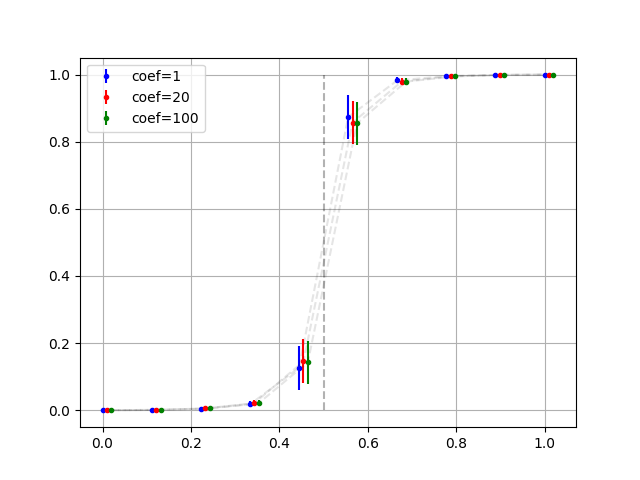

In [22]:
fig, ax = plt.subplots()

ax.errorbar(np.linspace(0, 1, 10), minus_fract.mean(axis=0)[0], yerr=minus_fract.std(axis=0)[0], fmt='.b', label='coef=1')
ax.plot(np.linspace(0, 1, 10), minus_fract.mean(axis=0)[0], '--k', alpha=0.1)

ax.errorbar(np.linspace(0, 1, 10) + 1e-2, minus_fract.mean(axis=0)[1], yerr=minus_fract.std(axis=0)[1], fmt='.r', label='coef=20')
ax.plot(np.linspace(0, 1, 10) + 1e-2, minus_fract.mean(axis=0)[1], '--k', alpha=0.1)

ax.errorbar(np.linspace(0, 1, 10) + 2e-2, minus_fract2.mean(axis=0)[0], yerr=minus_fract2.std(axis=0)[0], fmt='.g', label='coef=100')
ax.plot(np.linspace(0, 1, 10) + 2e-2, minus_fract2.mean(axis=0)[0], '--k', alpha=0.1)

ax.vlines(0.5, 0, 1, colors='black', linestyles='--', alpha=0.3)
ax.grid(True)
ax.legend()

plt.savefig('figures/community/stochast_erd_ren.png')